In [2]:
import gammapy
print(gammapy.__version__ , " == 1")

0.1.dev19174+g56b5bdf  == 1


In [3]:
import numpy as np
import os
import astropy
from astropy import units as u
from collections import OrderedDict
from astropy import units
from gammapy.data import DataStore
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.data import FixedPointingInfo, Observation, DataStore
from astropy.coordinates import SkyOffsetFrame
from gammapy.maps import WcsNDMap, WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.datasets import MapDataset
from gammapy.irf import load_cta_irfs, EDispKernel, PSFKernel
from gammapy.modeling import Fit

from gammapy.modeling.models import (
    Models,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion, RectangleSkyRegion


In [4]:
# define some functions for the geometry
def get_ebins():
    min_energy = 0
    ebins = np.logspace(-1,2,25)
    e_edges = ebins.copy()[np.where(ebins>=min_energy)[0][0]:]
    return e_edges*u.TeV

def get_geom():    

    geom_set = dict(
            width = (lon_width * u.deg, lat_width * u.deg),
            pix_size = pix_size * u.deg,
            e_edges  = get_ebins(),
            sky_dir = pks_pos,
            frame = 'icrs'
        )

    eaxis = MapAxis.from_edges(geom_set['e_edges'], name='energy', interp='log')

    geom = WcsGeom.create(
        skydir=geom_set['sky_dir'],
        binsz=geom_set['pix_size'],
        width=geom_set['width'],
        frame=geom_set['frame'],
        proj='CAR',
        axes=[eaxis],
    )

    geom_2d = geom.slice_by_idx(dict(energy=1))

    return geom, geom_2d



## Reading and peeking into the Datastore
The data is the HESS public PKS2155 steady runs. 
See info https://www.mpi-hd.mpg.de/HESS/pages/dl3-dr1/hess_dl3_dr1.pdf

In [5]:

#copied from /home/wecapstor1/caph/shared/hess/fits/fits_data/fits_paper_data.tar.gz
path = '/home/wecapstor1/caph/mppi045h/fits_paper_data/std_fullEnclosure/pks2155_steady/out'
path_saving = os.getcwd() 
data_store = DataStore.from_dir(path, f'hdu-index-bg-v05-fov-radec.fits.gz', f'obs-index-bg-v05-fov-radec.fits.gz')
hdul = fits.open(f"{path}/obs-index-bg-v05-fov-radec.fits.gz")
try:
    # File with all the obs ids to analyse
    obsid = 'obsid.txt'
    obsid = np.loadtxt(obsid)
except:
    string = ''
    for o in data_store.obs_ids:
        string += str(o) + '\n'
    print(string)
    with open('obsid.txt', 'w') as f:
        f.write(string)
    obsid = 'obsid.txt'
    obsid = np.loadtxt(obsid)




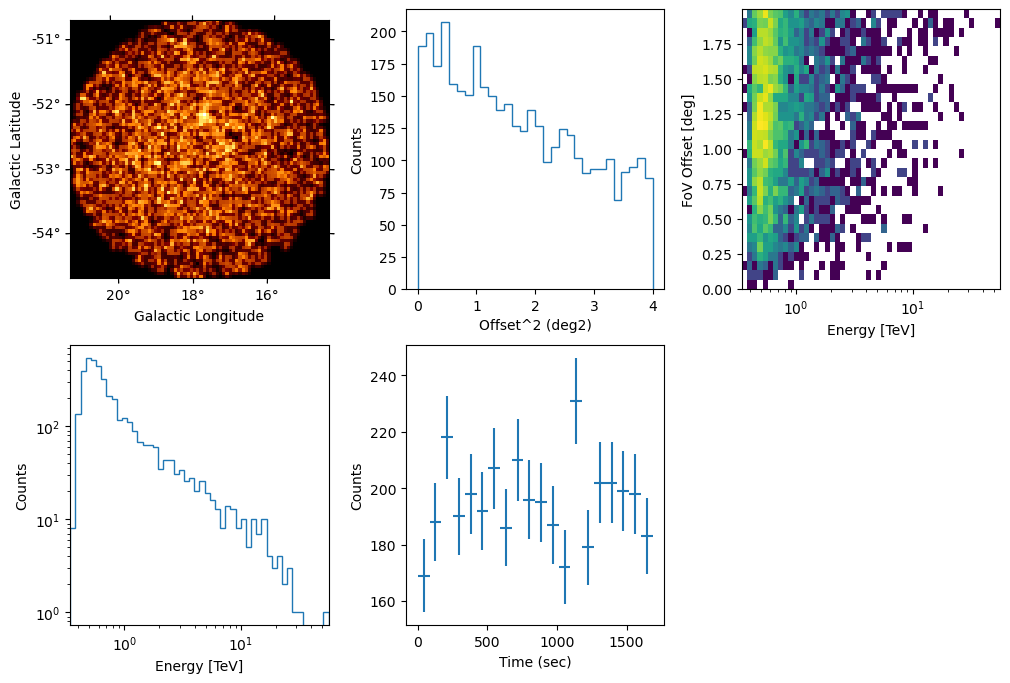

/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


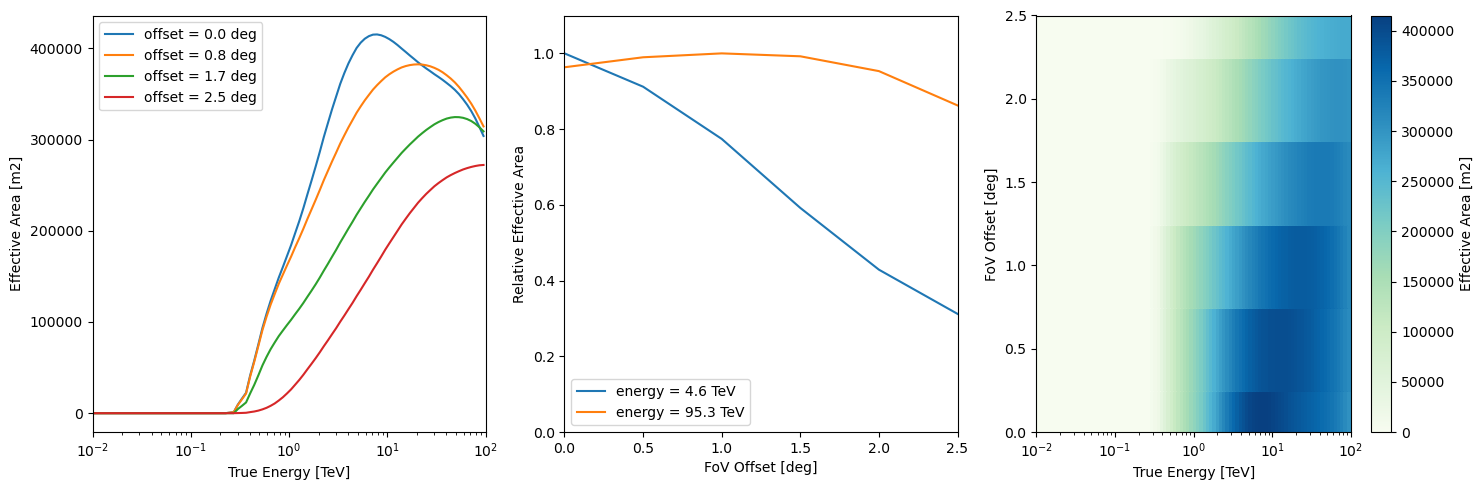

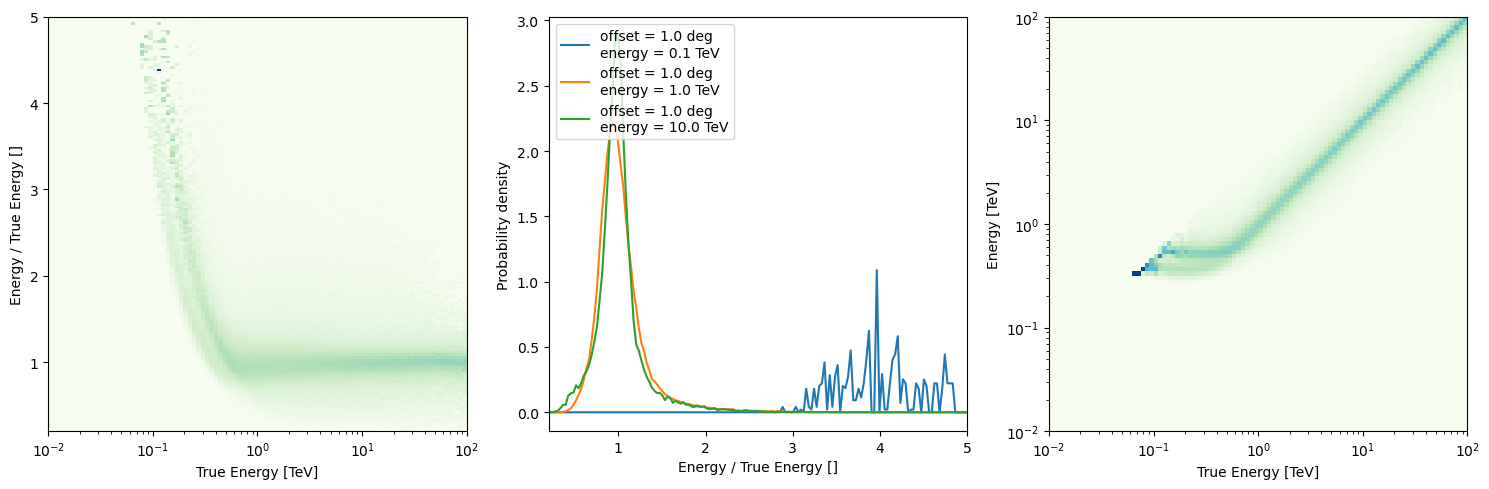

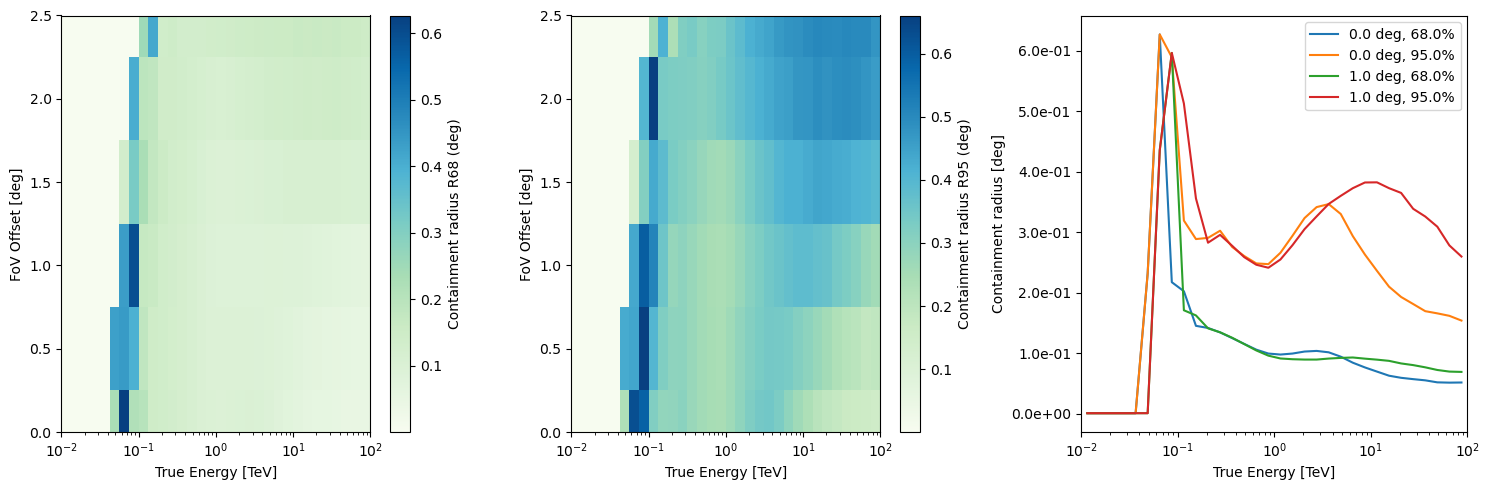

Missing 'HDUCLAS2' keyword assuming 'BKG'


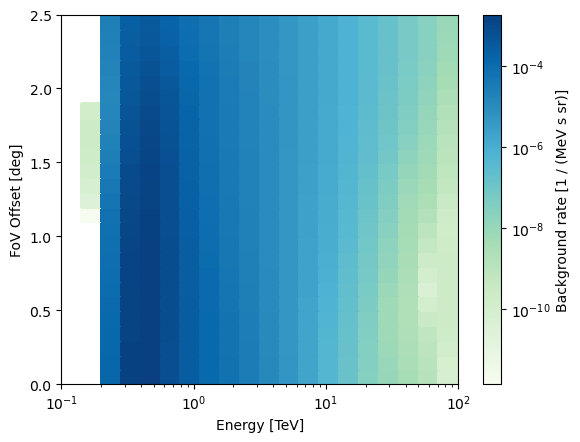

In [6]:
## looking at observation 0 as an example
import matplotlib.pyplot as plt

obs = data_store.obs(obsid[0])
obs.events.select_offset([0, 2] * u.deg).peek()
plt.show()

obs.aeff.peek()
plt.show()

obs.edisp.peek()
plt.show()

obs.psf.peek()
plt.show()

obs.bkg.to_2d().plot()
plt.show()

runs: 6
ontime: 2.81 hr
livetime: 2.81 hr
date: 2008-08-27-2008-08-28
avg zenith: 29.8 pm 5.36 deg
duration[max,min]: (28.15, 28.116666666666667)


Text(0.5, 0, 'Zenith [Deg]')

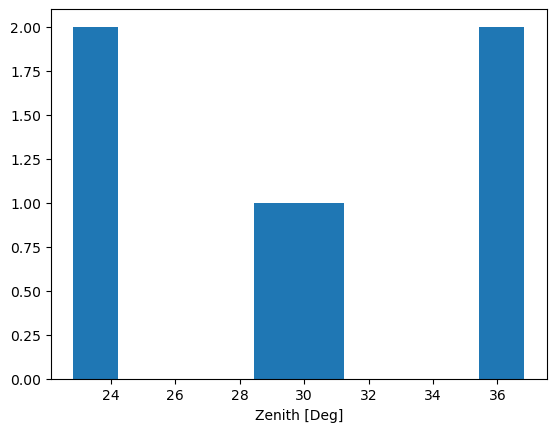

In [7]:
# some info 
ontime=[]
livetime=[]
timeobs=[]
date=[]
angle=[]
observations = data_store.get_observations(obsid)
for obs in observations:
    ontime.append(obs.obs_info['ONTIME'])
    livetime.append(obs.obs_info['LIVETIME'])
    timeobs.append(obs.obs_info['TSTOP']-obs.obs_info['TSTART'])
    #date.append(obs.obs_info['DATE-OBS'][0:4])
    date.append(obs.obs_info['DATE-OBS'])
    #angle.append(obs.obs_info['ZEN_PNT']) info not here anymore
    # compute zenith (0 at top) by 90 - altitude
    angle.append(90-obs.obs_info['ALT_PNT'])

timeobs=np.array(timeobs)
  
print(f'runs: {len(observations)}')
print(f'ontime: {np.sum(ontime)/3600:.3} hr')
print(f'livetime: {np.sum(livetime)/3600:.3} hr')
print('date:','{}-{}'.format(min(date),max(date)))
print(f'avg zenith: {np.mean(angle):.3} pm {np.std(angle):.3} deg')
print(f'duration[max,min]: {np.max(timeobs/60),np.min(timeobs/60)}')
#print('duration:',timeobs/60)
plt.hist(angle)
plt.xlabel('Zenith [Deg]')

In [8]:
# setting the position of the source
pks_pos = SkyCoord("21h58m43.2s", "-30d13m18s")
pks_pos = SkyCoord(frame = "galactic",l =  "17.74 deg", b= "-52.25 deg")
print(pks_pos)

<SkyCoord (Galactic): (l, b) in deg
    (17.74, -52.25)>


## 2. Computing the Energy Threshold
We want to analyse the data only above a certain energy threshold for which we are sure to have reconstructed the data well.

There are two criteria: 
1. The energy bias is smaller than 10 % (stored in ``threshold.txt``)
2. The background rate is smaller than the peak value. (stored in ``bkgthreshold.txt``)

In the end we will use the maximum value of those. 



### 2.1. Energy Bias < 10 % Threshold

In [9]:
# define txt files in which the two different thresholds are written into
store_threshold = 'threshold.txt'
store_bgthreshold = 'bkg_threshold.txt'

source = 'PKS'
config = 'std_ImPACT_fullEnclosure'
max_offset = 2.0 
min_energy = 0
ebins = get_ebins()
energy_binning = ebins.copy()[np.where(ebins>=min_energy)[0][0]:] #ebins.copy()[np.where(ebins>=min_energy)[0][0]-1:]





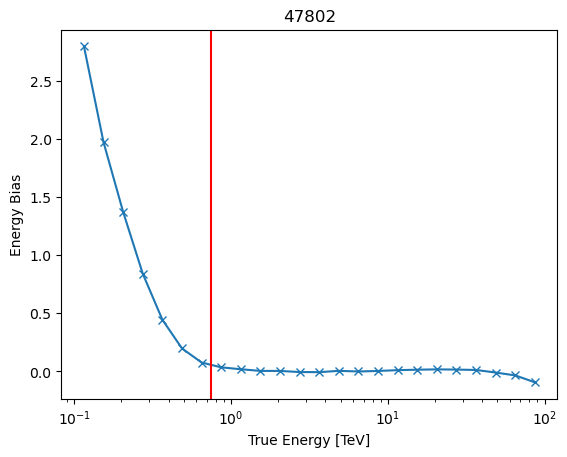

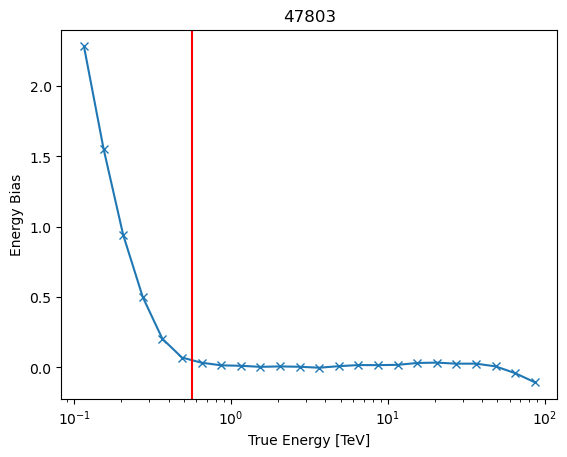

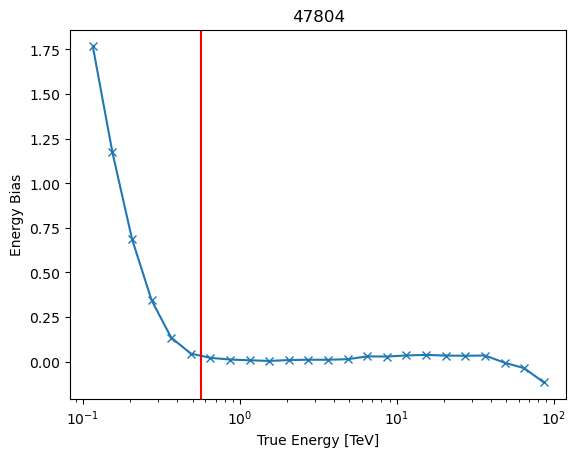

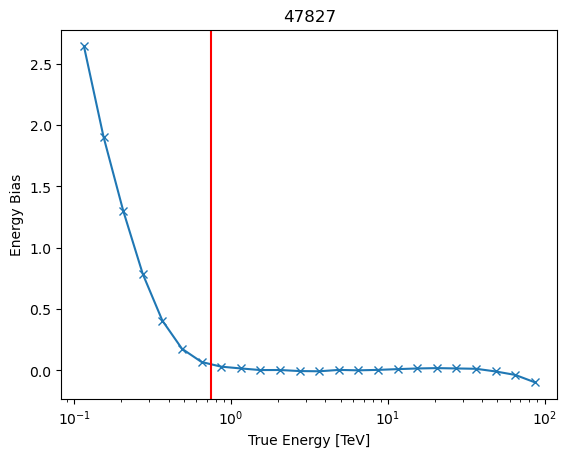

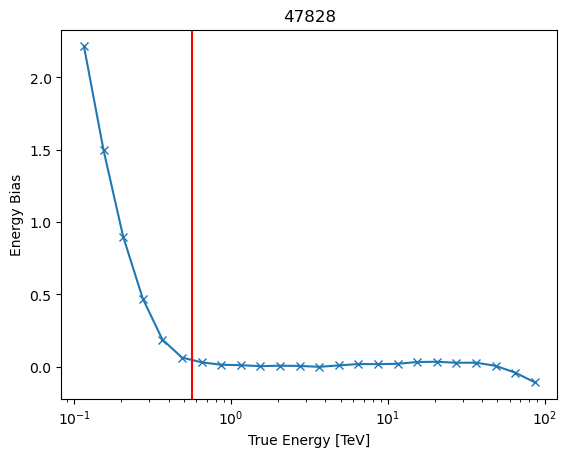

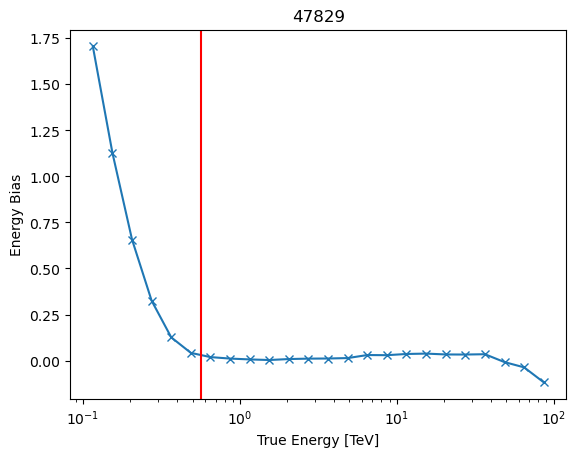

In [10]:

emax=10*units.TeV
# open file to print into
with open(store_threshold, 'w') as f:

    for obs in observations:
        thr_offset = max_offset * units.deg

        # extract energy dispersion for maximum offset
        edisp = obs.edisp.to_edisp_kernel(thr_offset, energy=energy_binning, energy_true=energy_binning)
        e_true = edisp.axes['energy_true'].center
        values = edisp.get_bias(e_true)
        plt.figure()
        # determine threshold from energy dispersion
        threshold = edisp.get_bias_energy(0.1,energy_min=e_true[np.nanargmax(values)],energy_max=emax)[0]
        if e_true[np.nanargmax(values)]>emax:
            threshold = edisp.get_bias_energy(0.1,energy_min=e_true[np.nanargmax(values[0:20])],energy_max=emax)[0]

        # use lower edge of first bin above threshold
        threshold = energy_binning[np.where(~(energy_binning.value[:-1]<threshold.value))[0][0]]

        threshold = np.floor(1e4*threshold)/1e4
        #print to file
        print(obs.obs_id, '  {:.4f}'.format(threshold.value),  file=f)
        print('')

        #if threshold.value>1:
        import matplotlib.pyplot as plt
        plt.plot(e_true,values, 'x-')
        plt.axvline(x=threshold.value,color='r', )
        plt.xscale('log')
        #plt.yscale('log')
        plt.xlabel("True Energy [TeV]")
        plt.ylabel("Energy Bias")
        plt.title(obs.obs_id)
        plt.show()



### 2.2. Background Peak Threshold



/tmp/ipykernel_1940499/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


t  47802


/tmp/ipykernel_1940499/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.6166 TeV
    max rate of 8795.18 1 / TeV in bin 5, upper edge 0.5623 TeV TeV
t  47803


/tmp/ipykernel_1940499/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4365 TeV
    max rate of 12666.68 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  47804


/tmp/ipykernel_1940499/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4074 TeV
    max rate of 15627.99 1 / TeV in bin 3, upper edge 0.3162 TeV TeV
t  47827


/tmp/ipykernel_1940499/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.6166 TeV
    max rate of 9189.38 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  47828


/tmp/ipykernel_1940499/527519777.py:22: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  skydir=obs.pointing_radec,
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: Use observation.pointing or observation.get_pointing_{altaz,icrs} instead
  val = self.fget(obj)
/home/wecapstor1/caph/mppi045h/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/utils/decorators.py:841: GammapyDeprecationWarning: The radec function is deprecated and may be removed in a future version.
  val = self.fget(obj)
Missing 'HDUCLAS2' keyword assuming 'BKG'


    threshold from aeff fits file is 0.4365 TeV
    max rate of 13045.97 1 / TeV in bin 4, upper edge 0.4216 TeV TeV
t  47829
    threshold from aeff fits file is 0.3802 TeV
    max rate of 15915.02 1 / TeV in bin 3, upper edge 0.3162 TeV TeV


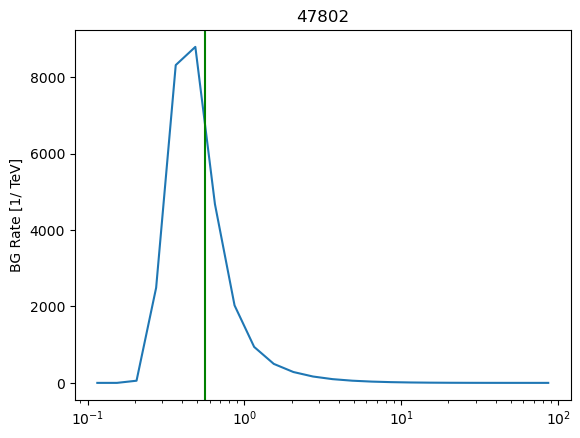

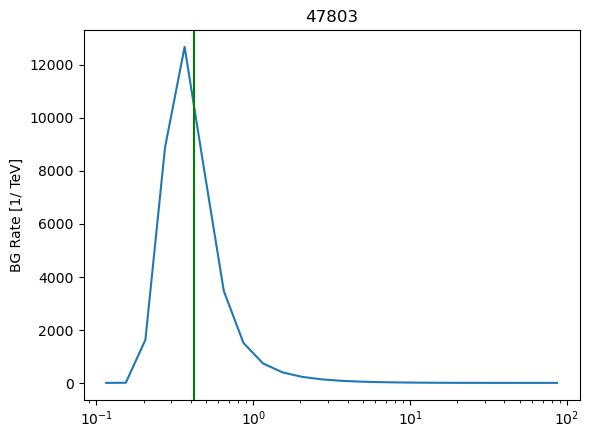

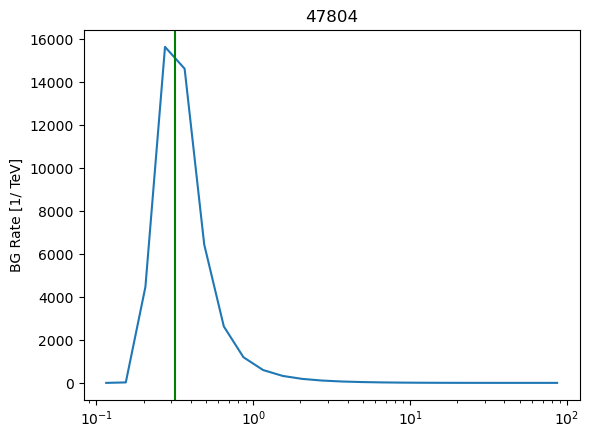

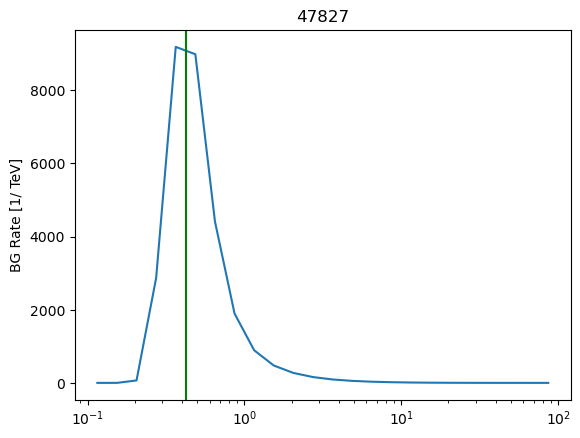

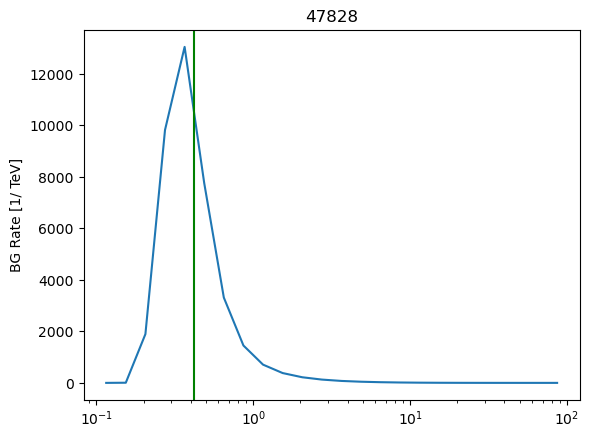

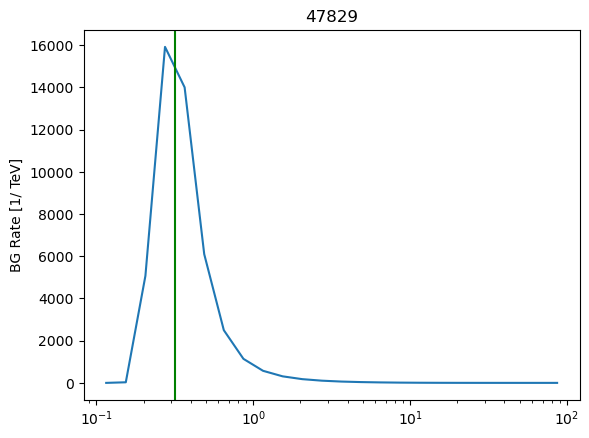

In [11]:

maker = MapDatasetMaker(background_oversampling=2, selection=['background'])
bgmodel_version = 'v08c'


min_energies = {}

# open file to print into
with open(store_bgthreshold, 'w') as f:

    ra_pnt = data_store.obs_table['RA_PNT']
    dec_pnt = data_store.obs_table['DEC_PNT']

    min_energies[source] = OrderedDict()

    for j in range(len(observations)):
        obs = observations[j]
        print('t ', obs.obs_id)
        e_thres = obs.aeff.meta['LO_THRES']
        eaxis = MapAxis.from_edges(get_ebins(), unit='TeV', name='energy', interp='log')

        geom = WcsGeom.create(
            skydir=obs.pointing_radec,
            binsz=0.02,
            width=(4.3, 4.3),
            frame='icrs',
            proj='CAR',
            axes=[eaxis],
        )
        bg_map = maker.make_background(geom, obs)


        bg_rate = bg_map.data.sum(axis=(1,2)) / np.diff(eaxis.edges)
        plt.figure()
        plt.plot(eaxis.center.value, bg_rate)
        plt.ylabel('BG Rate [1/ TeV]')
        plt.xscale('log')
        plt.title(obs.obs_id)
        
        print('    threshold from aeff fits file is {:.4f} TeV'.format(e_thres))
         # print to file
        print(obs.obs_id, '  {:.4f}'.format(e_thres), file=f)
        emin = eaxis.edges[1:][np.argmax(bg_rate)]
        emin = np.floor(1e4*emin)/1e4
        plt.axvline(x=emin.value,color='green', )
        
        print('    max rate of {:.2f} in bin {:d}, upper edge {:.4f} TeV'.format(np.max(bg_rate), np.argmax(bg_rate), emin))
        
        min_energies[source][obs.obs_id] = emin


## Compare Thresholds

In [12]:
thres_list = "threshold.txt"
thresholds = np.loadtxt(thres_list)
bgthres_list = "bkg_threshold.txt"
bgthresholds = np.loadtxt(bgthres_list)
#pick the one with max value
maxthreshold = np.array(list(map(max, zip(thresholds[:,1], bgthresholds[:,1]))))


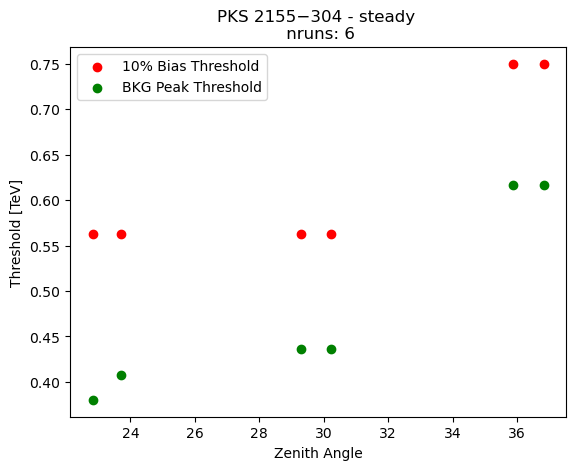

In [21]:
plt.scatter(angle,thresholds[:,1], label  = "10% Bias Threshold", color = 'r')
plt.scatter(angle,bgthresholds[:,1],label  = "BKG Peak Threshold", color = 'green')
plt.legend()
plt.xlabel("Zenith Angle")
plt.ylabel("Threshold [TeV]")
plt.title(f"PKS 2155−304 - steady \n nruns: {len(observations)}")
fig = plt.gcf()
fig.savefig("plots/1-thresholds_zenith.png")

## 3. Run-wise BKG Fitting and Dataset Creation

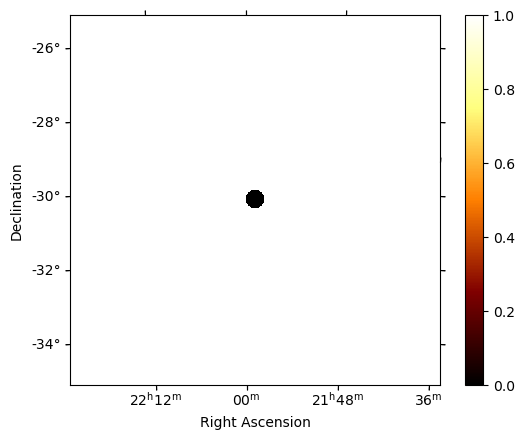

In [15]:
# define exclusion region around the source
excl_regions = []
lon_width,lat_width,pix_size = 10,10,0.02
radius = 0.25*u.deg
skyregion = CircleSkyRegion(center=pks_pos, radius=radius)
excl_regions = [skyregion]
excl_mask_2d = Map.from_geom(get_geom()[1], data=get_geom()[1].region_mask(excl_regions, inside=False).data)
excl_mask_2d.plot(add_cbar = 1, vmin =0, vmax = 1);

/tmp/ipykernel_1940499/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : 3YVqTGXx 

  Total counts                    : 1352 
  Total background counts         : 1317.55
  Total excess counts             : 34.45

  Predicted counts                : 1351.99
  Predicted background counts     : 1351.99
  Predicted excess counts         : 0.00

  Exposure min                    : 5.04e+01 m2 s
  Exposure max                    : 6.99e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 524729 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16656.64

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : 3YVqTGXx-bkg
    Datasets names            : ['3YVqTGXx']
    Spectral model type       : PowerLawNormSpectralModel
    Spatial  model type       : 
    Parameters:
      norm                          :      

/tmp/ipykernel_1940499/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1940499/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : k_7oOKXm 

  Total counts                    : 1468 
  Total background counts         : 1541.16
  Total excess counts             : -73.16

  Predicted counts                : 1467.93
  Predicted background counts     : 1467.93
  Predicted excess counts         : 0.00

  Exposure min                    : 1.03e+02 m2 s
  Exposure max                    : 5.71e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 556550 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17794.52

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : k_7oOKXm-bkg
    Datasets names            : ['k_7oOKXm']
    Spectral model type       : PowerLawNormSpectralModel
    Spatial  model type       : 
    Parameters:
      norm                          :     

/tmp/ipykernel_1940499/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1940499/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : SU2YDT9u 

  Total counts                    : 1170 
  Total background counts         : 1203.43
  Total excess counts             : -33.43

  Predicted counts                : 1169.90
  Predicted background counts     : 1169.90
  Predicted excess counts         : 0.00

  Exposure min                    : 4.08e+05 m2 s
  Exposure max                    : 4.93e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 556788 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14656.87

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : SU2YDT9u-bkg
    Datasets names            : ['SU2YDT9u']
    Spectral model type       : PowerLawNormSpectralModel
    Spatial  model type       : 
    Parameters:
      norm                          :     

/tmp/ipykernel_1940499/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1940499/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : c1s-e6-m 

  Total counts                    : 1302 
  Total background counts         : 1241.93
  Total excess counts             : 60.07

  Predicted counts                : 1301.86
  Predicted background counts     : 1301.86
  Predicted excess counts         : 0.00

  Exposure min                    : 6.44e+01 m2 s
  Exposure max                    : 6.79e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 524717 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 16203.18

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : c1s-e6-m-bkg
    Datasets names            : ['c1s-e6-m']
    Spectral model type       : PowerLawNormSpectralModel
    Spatial  model type       : 
    Parameters:
      norm                          :      

/tmp/ipykernel_1940499/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1940499/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : BviOzKvs 

  Total counts                    : 1402 
  Total background counts         : 1480.35
  Total excess counts             : -78.35

  Predicted counts                : 1402.00
  Predicted background counts     : 1402.00
  Predicted excess counts         : 0.00

  Exposure min                    : 5.62e+04 m2 s
  Exposure max                    : 5.56e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 556517 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 17037.77

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : BviOzKvs-bkg
    Datasets names            : ['BviOzKvs']
    Spectral model type       : PowerLawNormSpectralModel
    Spatial  model type       : 
    Parameters:
      norm                          :     

/tmp/ipykernel_1940499/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
/tmp/ipykernel_1940499/2059237105.py:13: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)
Missing 'HDUCLAS2' keyword assuming 'BKG'


MapDataset
----------

  Name                            : vhH4cXaX 

  Total counts                    : 1133 
  Total background counts         : 1146.35
  Total excess counts             : -13.35

  Predicted counts                : 1132.99
  Predicted background counts     : 1132.99
  Predicted excess counts         : 0.00

  Exposure min                    : 4.52e+05 m2 s
  Exposure max                    : 4.84e+08 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 556769 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 14319.50

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: FoVBackgroundModel
  
    Name                      : vhH4cXaX-bkg
    Datasets names            : ['vhH4cXaX']
    Spectral model type       : PowerLawNormSpectralModel
    Spatial  model type       : 
    Parameters:
      norm                          :     

/tmp/ipykernel_1940499/2059237105.py:32: GammapyDeprecationWarning: Use observation.get_pointing_icrs(time) instead
  [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True


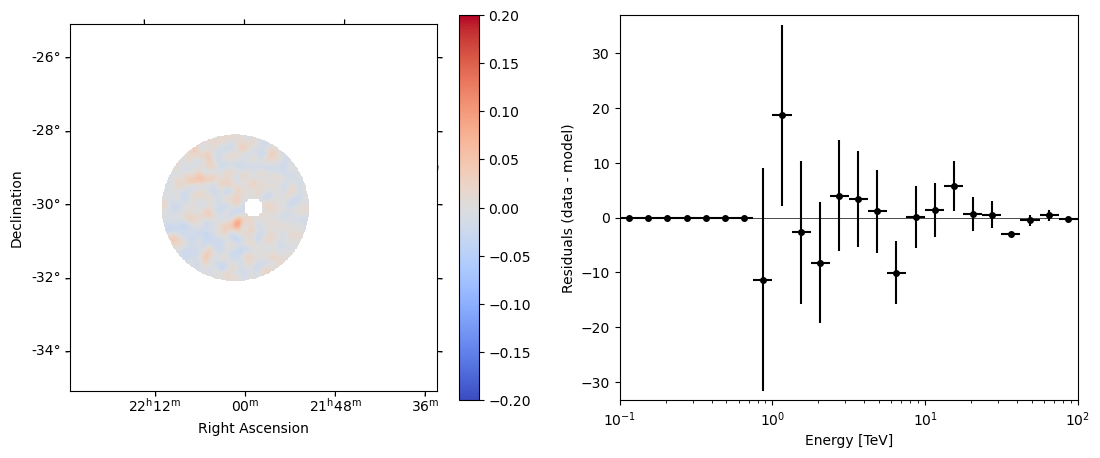

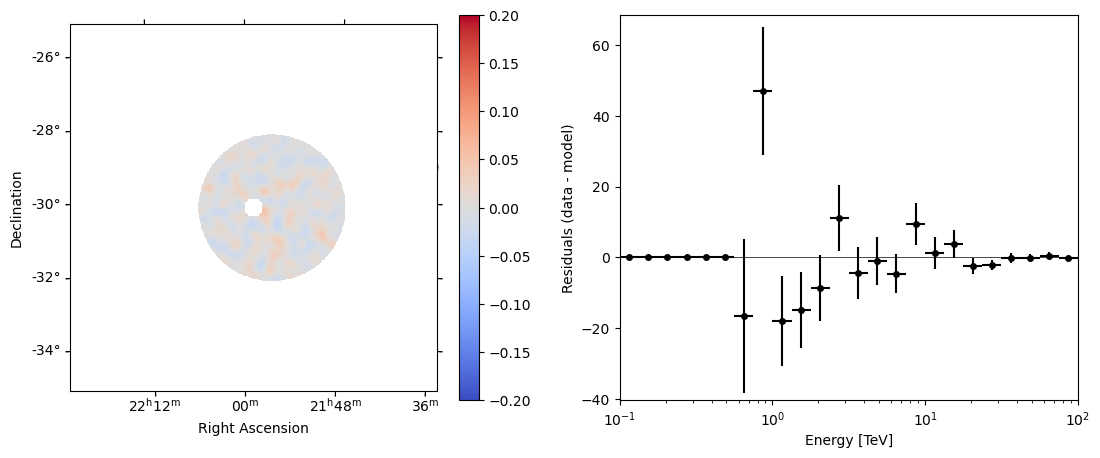

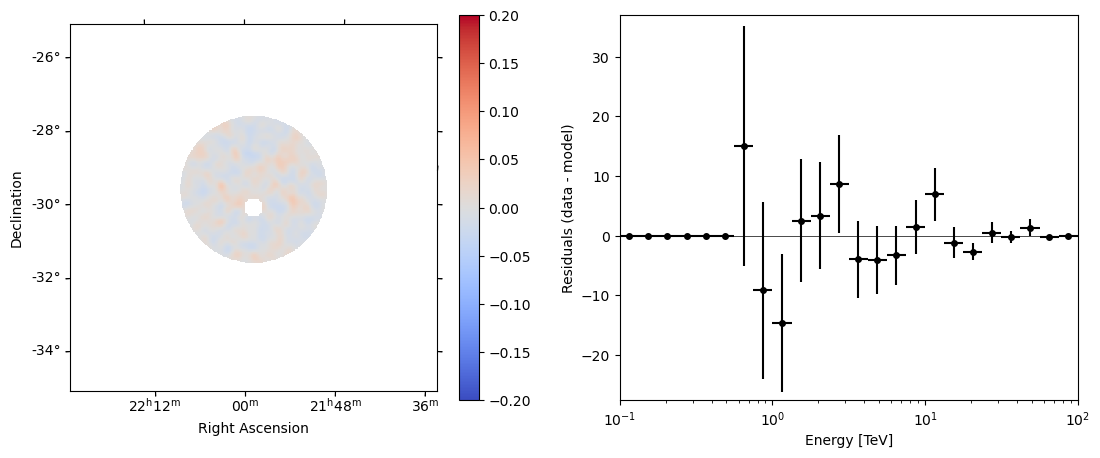

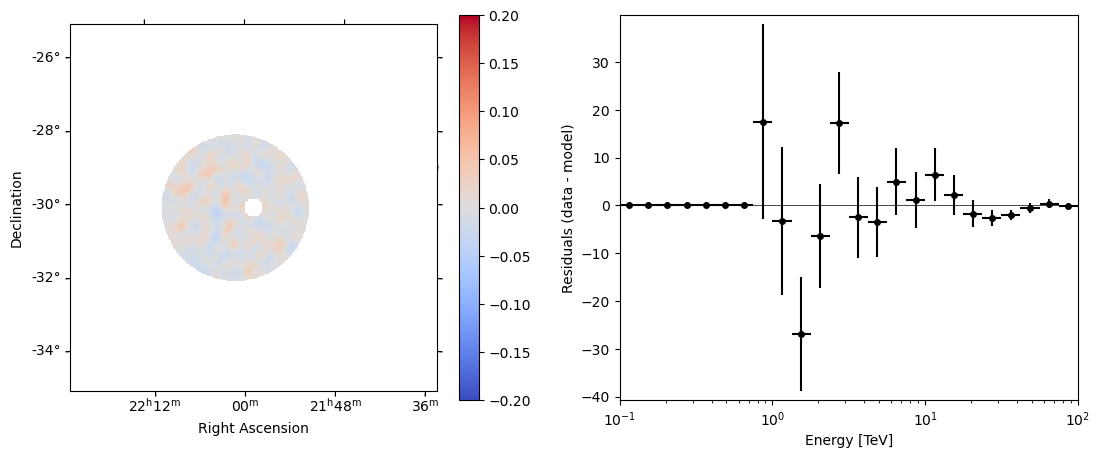

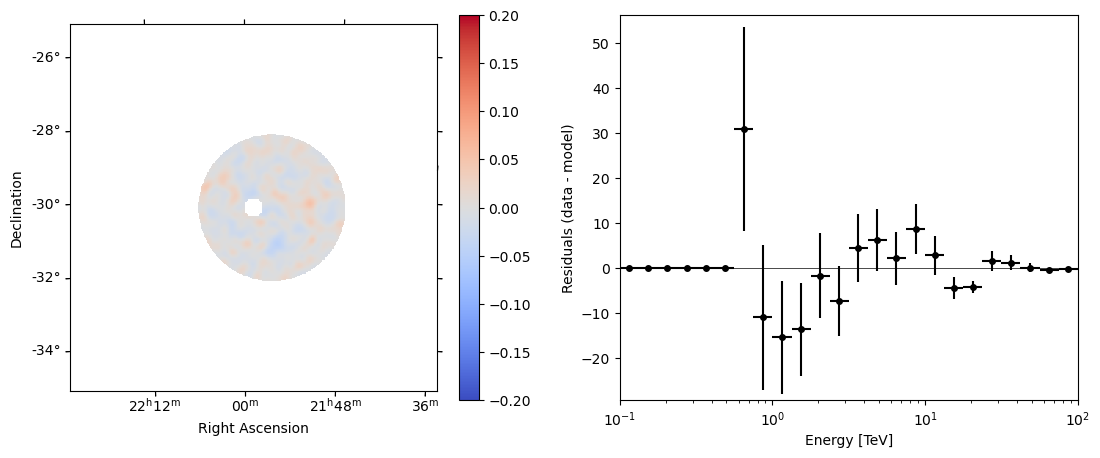

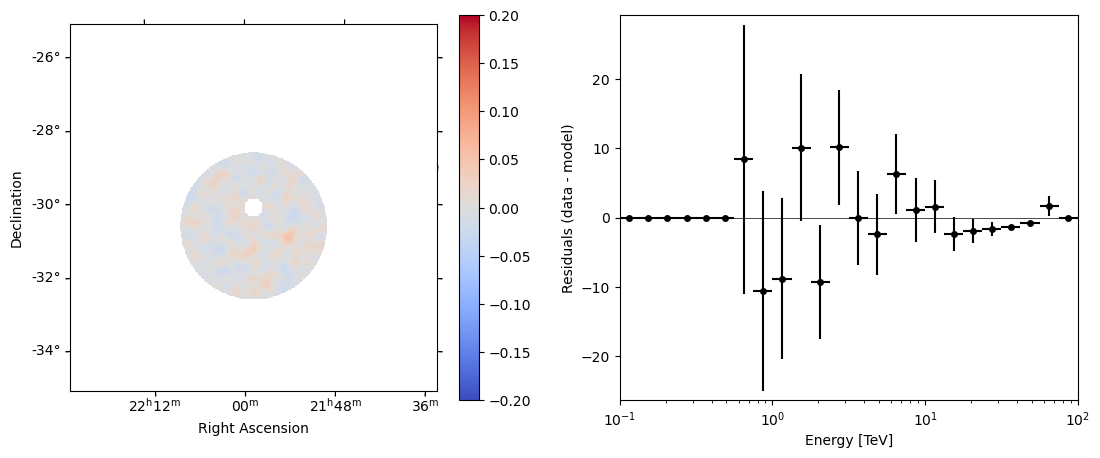

In [16]:

max_offset = 2*u.deg
geom = get_geom()[0]

maker = MapDatasetMaker(background_oversampling=2)
maker_safe_mask = SafeMaskMaker(methods=['offset-max'], offset_max=max_offset)
dataset_stacked = MapDataset.create(geom=geom, name='stacked')

bg_norms_  , bg_tilts_ = [], []

for i,obs in enumerate(observations):
    plt.figure(figsize = (13,5))
    
    reference = MapDataset.create(geom=geom, name='stacked').cutout(position=obs.pointing_radec, width=8.0*max_offset)    
    dataset = maker.run(reference, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    
    bkg_model = FoVBackgroundModel(dataset_name="{}".format(dataset.name))
    models = Models([bkg_model])
    dataset.models = models
    dataset.background_model.spectral_model.tilt.frozen = False

    dataset.mask_safe.data[:] &= excl_mask_2d.data
    ebins = get_ebins()
    emask = ebins[:-1].value >= maxthreshold[i]
    
    dataset.mask_safe.data[~emask,:,:] = False
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=[dataset])
    print(dataset)
    ax = dataset.plot_residuals(kwargs_spatial = {'vmax': 0.2, 'vmin': -0.2})
    mask_obs_max_offset = geom.to_image().region_mask(
        [CircleSkyRegion(obs.pointing_radec, radius=max_offset)], inside=True
    )
    dataset.mask_safe.data[emask] = dataset.mask_safe.data[emask] | mask_obs_max_offset

    assert np.isfinite(dataset.background.data[dataset.mask_safe.data]).all()
    dataset.background.data[~dataset.mask_safe.data] = 0.0

    dataset_stacked.stack(dataset)
    # save all datasets
    dataset.write('{}/dataset-obs-{}.fits.gz'.format(path_saving,obs.obs_id), overwrite=True)
    bg_norms, bg_tilts = np.array(dataset.background_model.parameters.value[:2])
    bg_norms_.append(dataset.background_model.parameters['norm'].value)
    bg_tilts_.append(dataset.background_model.parameters['tilt'].value)
    
        
dataset_stacked.write('{}/dataset-stacked.fits.gz'.format(path_saving), overwrite=True)


## Best Fit Results
The BKG normm should be distributed around 1, and the tilt around 0.

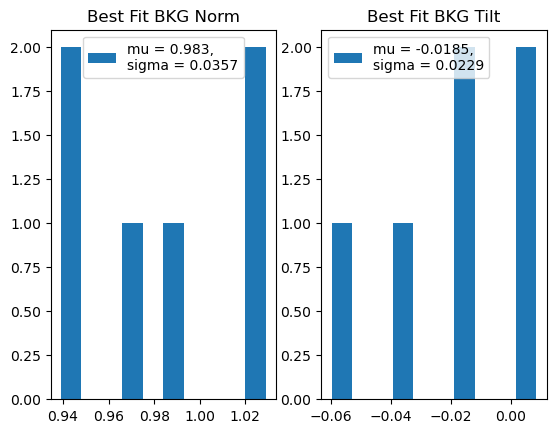

In [22]:
fig,axs = plt.subplots(1,2)
axs[0].hist(bg_norms_, label = f"mu = {np.mean(bg_norms_):.3}, \nsigma = {np.std(bg_norms_):.3}")
axs[1].hist(bg_tilts_, label = f"mu = {np.mean(bg_tilts_):.3}, \nsigma = {np.std(bg_tilts_):.3}")
axs[0].legend();axs[1].legend();
axs[0].set_title("Best Fit BKG Norm")
axs[1].set_title("Best Fit BKG Tilt")
fig.savefig("plots/1-best_fit-bkg.png")


<WCSAxes: >

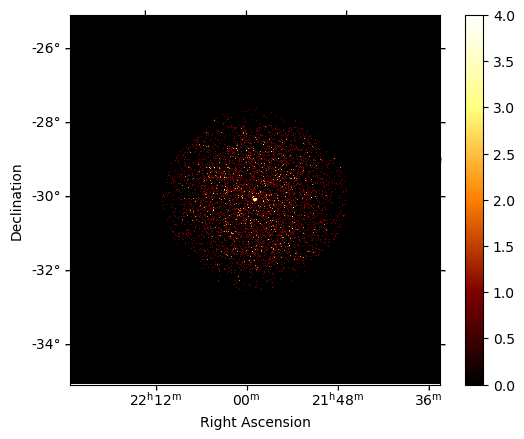

In [18]:
dataset_stacked.counts.sum_over_axes().plot(add_cbar = 1)